# Detekcija pronevere kod kreditnih kartica

# O DataSetu:

Dataset sadrži transakcije kreditnim karticama koje su se desile u dva dana, u septembru 2013 u Evropi. Imamo 492 pronevere od 284,807 transakcija. Dataset je jako nebalansovan, pozitivna klasa (pronevere) su 0.172% svih transakcija.

Zbog konfidencijalnih razloga feature-i V1, V2, ... V28 su prošli kroz PCA transformaciju i nemamo informacije o njima. Jedini feature-i koji nisu prošli kroz transformaciju su 'Time' i 'Amount'. 'Time' sadrži vreme koje je prošlo između prve transakcije i svake transakcije u datasetu. 'Amount' predstavlja količinu novca u transakciji. 'Class' ima vrednost 1 ako je u pitanju pronevera i 0 u suprotnom.


## Problem koji se rešava:

Bitno je da kompanije koje izdaju kreditne kartice mogu da prepoznaju lažne transakcije kreditnim karticama, da se klijentima ne naplaćuje roba koju nisu kupili. Isprojektovati predikcioni model koji precizno klasifikuje transakcije.


## Rezime dataseta:
<ul>
    <li>Nema null vrednosti.</li>
    <li>Većina feature-a je prošlo kroz PCA transformaciju. Da bi prošle kroz PCA transformaciju, vrednosti moraju prethodno biti skalirane</li>
    <li>Transakcije su izuzetno nebalansovane. Normalne su (99.828%) dok su pronevere (0.172%).</li>
</ul>

## Metrika kvaliteta i validacija resenja:

Kao metriku kvaliteta koristiće se recall score, a za validaciju resenja cross-validation.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import norm
import collections
import pickle

#Neural Network imports
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

#Oversampling (SMOTE)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('creditcard.csv')
print(data.head())

Using TensorFlow backend.


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [3]:
data.isnull().sum().max()

0

Nema null vrednosti.

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


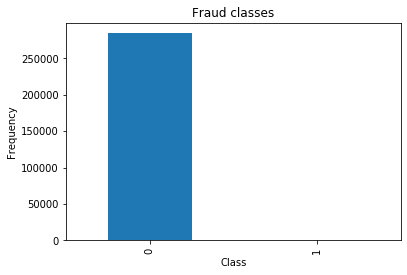

In [4]:
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
count_classes.plot(kind='bar')

print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100, 2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100, 2), '% of the dataset')

plt.title("Fraud classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# Pošto je većina kolona vec skalirana, trebalo bi skalirati i ostale kolone (Amount i Time).
Pravim nove kolone: scaled_time i scaled_amount koje ću zameniti u datasetu. Koristim RobustScaler jer bolje hendla outlier-e od StandardScaler-a.

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler

#std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1, 1))

# Hocu da dropujem kolone time i amount i da vratim skalirane kolone u dataset
data.drop(['Time', 'Amount'], axis=1, inplace=True)
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)

print("Normalizovane vrednosti: ")
print(data.head())

Normalizovane vrednosti: 
   scaled_amount  scaled_time        V1        V2        V3        V4  \
0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155   
1      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27   

# Separacija podataka od originalnog dataseta za trening skup

Koristim StratifiedKFold jer će se podaci shuffle-ovati jedanput na pocetku i podeliti na K delova, gde je test uvek jedan od delova. Kod StratifiedShuffleSplit može doci do preklapanja (overlap) u test setu. Posle pretvaram vrednosti u niz da bi bile spremne za testiranje.

In [6]:
X = data.drop('Class', axis=1)
y = data['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)  # koristim 5 splitova
for train_index, test_index in skf.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


# Undersampling

Ideja je da se napravi sub-sample sa odnosom 50/50 za klase da bi se stvorio balansovan odnos transakcija u datasetu.
Prvo sam sračunao da ima 492 instance pronevere, tj toliko puta se pojavi Class = 1. Najveća mana undersampling-a je što postoji rizik da klasifikacioni modeli nece biti toliko precizni, jer postoji ogroman gubitak informacija. (Korišćenje 492 obične transakcije od 284,315 običnih transakcija)

In [7]:
#Shuffle podataka. Nije obavezan.
data = data.sample(frac=1)

fraud_data = data.loc[data['Class'] == 1] # uzimam sve podatke gde je class = 1
print('Number of fraud transactions: ', len(fraud_data.index))
non_fraud_data = data.loc[data['Class'] == 0][:492]  # uzimam 492 podatka koji nisu fraud iz shuffle-ovanih podataka

normal_distributed_data = pd.concat([fraud_data, non_fraud_data])
# Shuffle dataframe rows
# Shuffle the data to see if our models can maintain a certain accuracy everytime we run this script
new_data = normal_distributed_data.sample(frac=1, random_state=42)
print('\n')
print(new_data.head())

Number of fraud transactions:  492


        scaled_amount  scaled_time        V1        V2        V3        V4  \
77055       -0.296793    -0.326907  1.283910  0.124914 -0.577868  0.685285   
237107      -0.307413     0.756635  1.184891  3.152084 -6.134780  5.531252   
192899       1.369384     0.531115 -1.881048 -1.789943  0.372067 -2.931045   
79883        3.465381    -0.310976 -1.322789  1.552768 -2.276921  2.992117   
163149      -0.069028     0.364184 -1.550273  1.088689 -2.393388  1.008733   

              V5        V6        V7        V8  ...       V20       V21  \
77055   0.805750  0.860454  0.019234  0.214941  ... -0.205627 -0.082431   
237107  1.733867 -1.816861 -0.916696  0.265568  ...  0.336442  0.124236   
192899  0.324594 -0.204295 -0.392266  0.048830  ... -0.549847 -0.329539   
79883  -1.947064 -0.480288 -1.362388  0.953242  ...  0.988493  0.614969   
163149 -1.087562 -1.104602 -2.670503  0.147655  ...  0.327490  0.802316   

             V22       V23       V24       

# Oversampling (SMOTE)

Smote(Synthetic Minority Oversampling Technique) kreira nove sintetičke transakcije manjinske klase, da bi stvorio balans u datasetu. Smote bira distancu između najbližih komšija manjinske klase i izmedju njih kreira nove sintetičke tačke (transakcije). Time nismo izgubili informacije kao kod undersampling-a i verovatnije je da će model biti precizniji, ali će zahtevati vise vremena za obučavanje.

In [8]:
sm = SMOTE(ratio='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

# Istraživanje korelacija izmedju feature-a

Korelacione matrice su nam bitne da bismo zaključili kako koji feature-i utiču na to da li je transakcija pronevera ili nije. Neophodno je da dataset bude balansovan da bismo mogli da vidimo koji feature-i imaju visoku pozitivnu ili negativnu korelaciju sa klasifikacijom(Class feature-om).

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


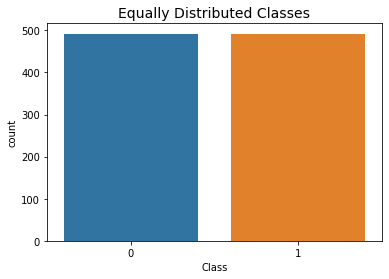

Distribution of the Classes in the oversample dataset
After OverSampling, counts of label '1': 227452
After OverSampling, counts of label '0': 227452


In [9]:

print('Distribution of the Classes in the subsample dataset')
print(new_data['Class'].value_counts()/len(new_data))

sns.countplot('Class', data=new_data)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

print('Distribution of the Classes in the oversample dataset')
print("After OverSampling, counts of label '1': {}".format(sum(ysm_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(ysm_train==0)))

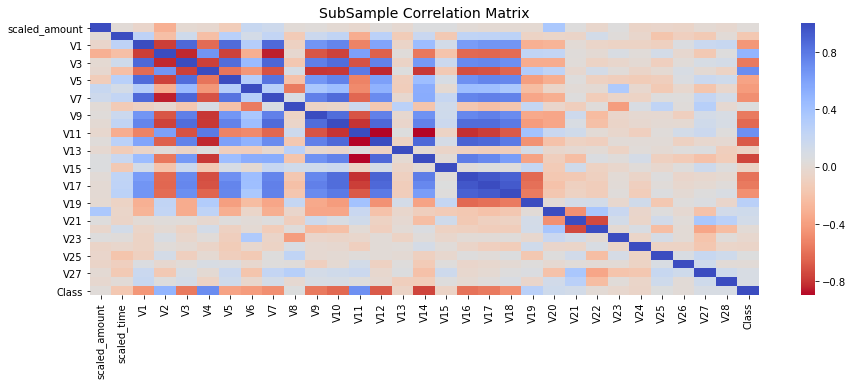

In [10]:
f,  ax2 = plt.subplots(1, 1, figsize=(15, 5))

sub_sample_corr = new_data.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

# Šta smo zaključili?

Visoku pozitivnu korelaciju sa feature-om 'Class' imaju: V2, V4, V11, V19
Visoku negativnu korelaciju sa feature-om 'Class' imaju: V10, V12, V14, V17

Negativna korelacija znaci da što je vrednost našeg feature-a manja, to je veća verovatnoća da će transakcija biti pronevera.
Pozitivna korelacija znaci da što je vrednost našeg feature-a veća, to je veća verovatnoća da će transakcija biti pronevera.

![title](outliers.png)

Text(0.5, 1.0, 'V10 vs Class Negative Correlation')

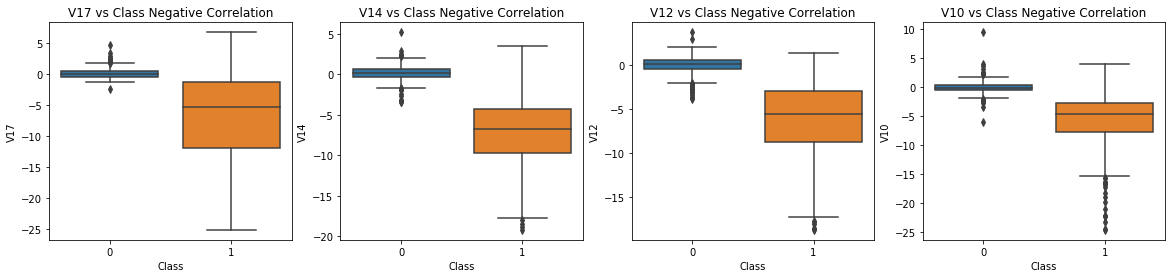

In [11]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_data, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V14", data=new_data,  ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_data,  ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_data, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')
#plt.show()

Text(0.5, 1.0, 'V19 vs Class Positive Correlation')

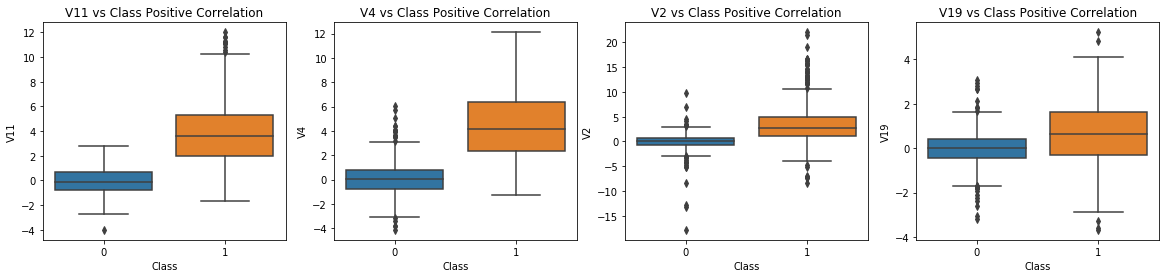

In [12]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=new_data,  ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_data,  ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_data,  ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_data,  ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

#plt.show()

# Uklanjanje outlier-a (Interquartile range method)

Outlier-i su opservacije koje su jako retke, jedinstvene i ne uklapaju se. Često su posledica grešaka, korupcije podataka, a nekad mogu da budu tačne.

IQR(Interquartile range method) je statistički metod za uklanjanje outlier-a. Ideja je da se uklone ekstremni outlieri da bismo poboljšali preciznost modela, pri čemu se mora paziti da ne dođe do gubitka informacija sto bi prouzrokovalo manju preciznost modela. IQR odseca krajeve distribucije i ostavlja glavni deo. Za prag odsecanja koristicemo vrednost 1.5

<ul>
    <li>Prvo ćemo vizualizovati distribucije vrednosti feature-a koji utiču na klasu. V14 je jedini feature koji ima normalnu distribuciju.</li>
    <li>Odredićemo granicu odsecanja tako što ćemo od q25 oduzeti razliku (q75-q25)*1.5 dok ćemo q75 sabrati sa istim. Sve vrednosti koje su ispod ili iznad ove granice će biti uklonjene.</li>
<ul>
    


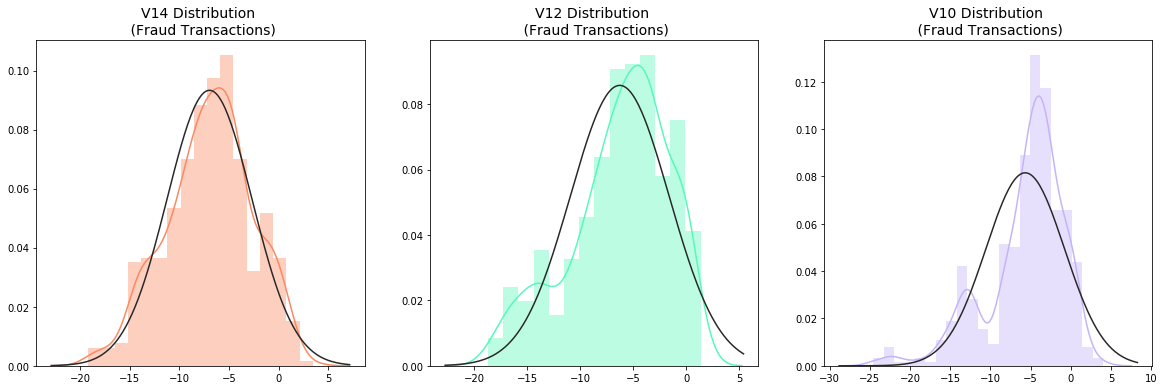

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
v14_fraud_dist = new_data['V14'].loc[new_data['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_data['V12'].loc[new_data['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_data['V10'].loc[new_data['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [14]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_data['V14'].loc[new_data['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_data = new_data.drop(new_data[(new_data['V14'] > v14_upper) | (new_data['V14'] < v14_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_data)))
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_data['V12'].loc[new_data['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_data = new_data.drop(new_data[(new_data['V12'] > v12_upper) | (new_data['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_data)))
print('----' * 44)

# Removing outliers V10 Feature
v10_fraud = new_data['V10'].loc[new_data['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_data = new_data.drop(new_data[(new_data['V10'] > v10_upper) | (new_data['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_data)))

V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.049997689859396, -19.2143254902614, -18.8220867423816, -18.4937733551053]
Number of Instances after outliers removal: 979
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.4311310279993, -18.047596570821604, -18.683714633344298, -18.553697009645802]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-16.3035376590131, -16.6496281595399, -18.9132433348732, -17.141513641289198, -24.588262

# Klasifikatori (Undersampling)

Sada ćemo istrenirati četiri klasifikatora da detektuju lažne transakcije, tj pronevere. U ovom delu testiraćemo klasifikatore na subsample-u. Koristićemo logisticku regresiju, KNearestNeighbours, Support Vector Machine i Decision Tree klasifikatore. Logistička regresija pokazuje najbolje rezultate na obučavajućem skupu. Drugi najbolji klasifikator je SVM.

Prvo ćemo da podelimo podatke iz sumbsample-a u setove za obučavanje i testiranje.

<b>Logistička regresija</b> modeluje i procenjuje verovatnoću da će se neki događaj desiti, i verovatnoću da se neće desiti za datu opservaciju u zavisnosti od parametara. Ili procenjuje verovatnoću da je opservacija u određenoj kategoriji. Linearna regresija koristi jednu kvantitativnu varijablu da bi procenila drugu kvantitativnu varijablu. U ovom slučaju lin. regresija neće proći zato što klasa pronevere je dihotomna varijabla (1 ili 0) i nije kvantitativna.

![title](logReg.png)

Kad su klase linearno separabilne, <b>SVM</b> će naći hiperravan sa najvećom marginom da ih razdvoji, i to će biti optimalna hiperravan. Kad klase nisu linearno separabilne SVM će imati stepen tolerancije, tj koliko će tačaka da dozvoli da se pogrešno klasifikuju. Prednosti su mu što može da modeluje i linearno separabilne i neseparabilne i garantuje optimalnost.

![title](svm.png)

<b>Decision Trees</b> (DTs) je metod nadgledanog učenja koji se koristi za klasifikaciju i regresiju. Decision trees koriste if-then-else pravila odlučivanja. Što je dublje stablo, to su kompleksnija pravila odlučivanja i model je kvalitetniji.


![title](dt.png)

<b>KNN</b> pamti obučavajući skup i pronalazi K najbližih komšija iz istog za svaku opservaciju, zatim se glasa kojoj klasi više pripada, što znači da će testiranje dugo da traje dok je obučavanje brzo. Može da modeluje bilo kakvo razdvajanje među podacima i dobar je za velike obučavajuće skupove.

![title](knn.png)

In [15]:
X = new_data.drop('Class', axis=1)
y = new_data['Class']

# Ovo se koristi samo za undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
}

In [16]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5) # 5 zbog broja foldova
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of",
          round(training_score.mean(), 2) * 100, "% accuracy score")



Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 92.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 90.0 % accuracy score


# GridSearchCV

U ovom delu koristimo GridSearchCV da bismo našli optimalne parametre za klasifikatore.

In [17]:
# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train,y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

# KNearestNeighbours
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# tree best estimator
tree_clf = grid_tree.best_estimator_

## Testiranje

U ovom segmentu testiramo modele obučene na undersample datasetu.

In [18]:

from sklearn.metrics import recall_score

print('----TESTING UNDERSAMPLING----')
print('\nCross-validation:')
log_reg_score = cross_val_score(log_reg, X_test, y_test, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_test, y_test, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_test, y_test, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_test, y_test, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

print('\nRecall score:')
# Logistic Regression with Under-Sampling
y_pred_log_reg = log_reg.predict(original_Xtest)
log_reg_undersample_score = recall_score(original_ytest, y_pred_log_reg)
print('Logistic Regression UnderSample Test Recall Score: {}'.format(log_reg_undersample_score))

# KNN with Under-Sampling
y_pred_knears = knears_neighbors.predict(original_Xtest)
knears_undersample_score = recall_score(original_ytest, y_pred_knears)
print('KNN UnderSample Test Recall Score: {}'.format(knears_undersample_score))

# SVC with Under-Sampling
y_pred_svc = svc.predict(original_Xtest)
svc_undersample_score = recall_score(original_ytest, y_pred_svc)
print('SVC UnderSample Test Recall Score: {}'.format(svc_undersample_score))

# DecisionTree with Under-Sampling
y_pred_tree_clf = tree_clf.predict(original_Xtest)
tree_clf_undersample_score = recall_score(original_ytest, y_pred_tree_clf)
print('Tree_clf UnderSample Test Recall Score: {}'.format(tree_clf_undersample_score))

print('\nCLASSIFICATION REPORT (UNDERSAMPLE) : ')
print('Logistic Regression:')
print(classification_report(original_ytest, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(original_ytest, y_pred_knears))

print('Support Vector Classifier:')
print(classification_report(original_ytest, y_pred_svc))

print('Decision Tree Classifier:')
print(classification_report(original_ytest, y_pred_tree_clf))

----TESTING UNDERSAMPLING----

Cross-validation:
Logistic Regression Cross Validation Score:  91.54%
Knears Neighbors Cross Validation Score 92.03%
Support Vector Classifier Cross Validation Score 92.03%
DecisionTree Classifier Cross Validation Score 90.45%

Recall score:
Logistic Regression UnderSample Test Recall Score: 0.8775510204081632
KNN UnderSample Test Recall Score: 0.8877551020408163
SVC UnderSample Test Recall Score: 0.9183673469387755
Tree_clf UnderSample Test Recall Score: 0.8571428571428571

CLASSIFICATION REPORT (UNDERSAMPLE) : 
Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56863
           1       0.05      0.88      0.10        98

    accuracy                           0.97     56961
   macro avg       0.53      0.92      0.54     56961
weighted avg       1.00      0.97      0.98     56961

KNears Neighbors:
              precision    recall  f1-score   support

           0       1.00      

## Klasifikatori (Oversampling)

Iskoristićemo best_estimator parametre od malo pre i svaki od klasifikatora ćemo da obučimo na oversample datasetu.

In [19]:
import time

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Logistic Regression fitting oversample data took :{} sec".format(t1 - t0))

# KNN
t2 = time.time()
knears_sm = grid_knears.best_estimator_
knears_sm.fit(Xsm_train, ysm_train)
t3 = time.time()
print("KNN fitting oversample data took :{} sec".format(t3 - t2))

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_

# SVM
#t4 = time.time()
#svc_sm = grid_svc.best_estimator_
#svc_sm.fit(Xsm_train, ysm_train)
#t5 = time.time()
#print("SVM fitting oversample data took :{} sec".format(t5 - t4))

## DecisionTrees
t6 = time.time()
tree_clf_sm = grid_tree.best_estimator_
tree_clf_sm.fit(Xsm_train, ysm_train)
t7 = time.time()
print("Decision Tree fitting oversample data took :{} sec".format(t7 - t6))

Logistic Regression fitting oversample data took :14.823848009109497 sec
KNN fitting oversample data took :7.282416582107544 sec
Decision Tree fitting oversample data took :7.83944845199585 sec


In [20]:
print('----TESTING OVERSAMPLING----')

y_pred_log_reg_sm = log_reg_sm.predict(original_Xtest)
y_pred_knears_sm = knears_sm.predict(original_Xtest)
#y_pred_svc_sm = svc_sm.predict(original_X_test)
y_pred_tree_clf_sm = tree_clf_sm.predict(original_Xtest)

print('\nCLASSIFICATION REPORT (OVERSAMPLE) : ')
print('Logistic Regression:')
print(classification_report(original_ytest, y_pred_log_reg_sm))

print('KNears Neighbors:')
print(classification_report(original_ytest, y_pred_knears_sm))

#print('Support Vector Classifier:')
#print(classification_report(original_ytest, y_pred_svc_sm))

print('Decision Tree Classifier:')
print(classification_report(original_ytest, y_pred_tree_clf_sm))

----TESTING OVERSAMPLING----

CLASSIFICATION REPORT (OVERSAMPLE) : 
Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.12      0.87      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.93      0.60     56961
weighted avg       1.00      0.99      0.99     56961

KNears Neighbors:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.66      0.81      0.72        98

    accuracy                           1.00     56961
   macro avg       0.83      0.90      0.86     56961
weighted avg       1.00      1.00      1.00     56961

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.84      0.07        98

    accuracy                           0.96     5

# Neuronska mreža

U ovom delu implementiracemo neuronsku mrežu. Cilj je da vidimo kako se mreža ponaša u undersample i oversample datasetovima i da vidimo koliko precizno mreža klasifikuje pronevere. Takođe je bitno da mreža dobro klasifikuje i obične transakcije.

Mreža će imati dva skrivena sloja od po 32 cvora, broj cvorova ulaznog sloja je broj feature-a i jedan bias čvor, što je ukupno 32, i jedan izlazni čvor koji može dati rezultat 1 ili 0. (Pronevera ili nije)

Learning rate će biti 0.001, optimizator AdamOptimizer, aktivaciona funkcija Relu i sparse categorical cross entropy koja daje verovatnoću da li je slucaj pronevera ili nije i odabrace slučaj sa većom verovatnoćom.

In [21]:
# ---------UNDERSAMPLE MODEL---------
n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

undersample_model.summary()
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

print('Neural Net (Undersample):')
print(classification_report(original_ytest, undersample_fraud_predictions))


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 3,044
Trainable params: 3,044
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 605 samples, validate on 152 samples
Epoch 1/20
 - 4s - loss: 0.5613 - acc: 0.6496 - val_loss: 0.3986 - val_acc: 0.8158
Epoch 2/20
 - 0s - loss

In [22]:
# ---------OVERSAMPLE MODEL---------
n_inputs = Xsm_train.shape[1] # broj feature-a (32)

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

undersample_model.summary()
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

print('Neural Net (Oversample(SMOTE)):')
print(classification_report(original_ytest, oversample_fraud_predictions))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 3,044
Trainable params: 3,044
Non-trainable params: 0
_________________________________________________________________
Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 8s - loss: 0.0563 - acc: 0.9808 - val_loss: 0.0114 - val_acc: 0.9986
Epoch 2/20
 - 9s - loss: 0.0103 - acc: 0.9979 - val_loss: 0.0043 - val_acc: 0.9997
Epoch 3/20
 - 11s - loss: 0.0068 - acc: 0.9988 - val_lo

## Zaključak

Modeli koji su se najbolje pokazali u detekciji pronevera su Logistic regression i SVM. Implementirajuci SMOTE na modele dobili smo poboljšanu klasifikaciju običnih transakcija nego u modelima obučenim na undersamplingu, što je isto bitno jer u realnoj situaciji ne bi bilo poželjno da veliki broj ljudi pravi normalne transakcije i da im banka blokira karticu zato što je model klasifikovao slučaj kao proneveru. Sa druge strane, modeli obuceni na SMOTE su se lošije pokazali u detekciji pronevera nego modeli obučeni na udersample datasetu, ali brisanje outlier-a je odrađeno samo na undersample datasetu, sledeći korak za poboljšanje kvaliteta bi bio implementirati isto i na oversample-ovanom datasetu.